In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
df = pd.read_csv("model_input_data.csv")

In [3]:
df

,Unnamed: 0,Age,sex_binari,Cholesterol,Blood_Pressure_low,Blood_Pressure_high,Heart Rate,Diabetes,Family History,Smoking,...,Alcohol Consumption,Exercise Hours Per Week,diet_int,Previous Heart Problems,Medication Use,Stress Level,BMI,Triglycerides,Sleep Hours Per Day,Heart Attack Risk
0,0,67,0,208,88,158,72,0,0,1,...,0,4.168189,0,0,0,9,31.251233,286,6,0
1,1,21,0,389,93,165,98,1,1,1,...,1,1.813242,-1,1,0,1,27.194973,235,7,0
2,2,21,1,324,99,174,72,1,0,0,...,0,2.078353,1,1,1,9,28.176571,587,4,0
3,3,84,0,383,100,163,73,1,1,1,...,1,9.828130,0,1,0,9,36.464704,378,4,0
4,4,66,0,318,88,91,93,1,1,1,...,0,5.804299,-1,1,0,6,21.809144,231,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,8758,60,0,121,76,94,61,1,1,1,...,1,7.917342,1,1,1,8,19.655895,67,7,0
8759,8759,28,1,120,102,157,73,1,0,0,...,0,16.558426,1,0,0,8,23.993866,617,9,0
8760,8760,47,0,250,75,161,105,0,1,1,...,1,3.148438,0,1,0,5,35.406146,527,4,1
8761,8761,36,0,178,67,119,60,1,0,1,...,0,3.789950,-1,1,1,5,27.294020,114,8,0


In [4]:
### Creating dataset class
##########################

class HeartAttackRiskData(Dataset):
    def __init__(self, inputs, outputs) -> None:
        super().__init__()
        self.n = len(inputs)
        self.i = 0
        self.inputs = inputs
        self.outputs = outputs
    
    def __getitem__(self, index) -> any:
        input = self.inputs[self.i]
        output = self.outputs[self.i]
        #input = df.loc[self.i][1:-1]
        #output = df.loc[self.i][-1]
        #input_tensor = torch.tensor(np.array(input))
        #output_tensor = torch.tensor(np.array([output]))
        self.i = self.i+1
        if self.i == self.n:
            self.i = 0
        return torch.tensor(np.array(input)), torch.tensor(np.array([output]))

    def __len__(self):
        return self.n

In [5]:
### Spliting data in training and testing. Making loader objects for easyly feed the model
##########################################################################################

# shuffling the data
df = df.sample(frac = 1)

# making the training and testing dataset from all available data
train_df_index = int(0.8*len(df))
df_train = df.iloc[0:train_df_index]
df_test = df.iloc[train_df_index:len(df)]
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
inputs_train = torch.tensor(np.array([df_train.iloc[i].iloc[1:-1] for i in range(len(df_train))])).type(torch.FloatTensor)
outputs_train = torch.tensor(np.array([df_train.iloc[i].iloc[-1] for i in range(len(df_train))])).type(torch.FloatTensor)
inputs_test = torch.tensor(np.array([df_test.iloc[i].iloc[1:-1] for i in range(len(df_test))])).type(torch.FloatTensor)
outputs_test = torch.tensor(np.array([df_test.iloc[i].iloc[-1] for i in range(len(df_test))])).type(torch.FloatTensor)
#outputs_train = [torch.tensor(np.array(df_train.iloc[i].iloc[-1])).type(torch.FloatTensor) for i in range(len(df_train))]
#inputs_test = [torch.tensor(np.array(df_test.iloc[i].iloc[1:-1])).type(torch.FloatTensor) for i in range(len(df_test))]
#outputs_test = [torch.tensor(np.array(df_test.iloc[i].iloc[-1])).type(torch.FloatTensor) for i in range(len(df_test))]
train_data = HeartAttackRiskData(inputs_train, outputs_train)
test_data = HeartAttackRiskData(inputs_test, outputs_test)

# making data loader objects
train_loader = DataLoader(train_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

In [6]:
for input, output in train_loader:
    print(input)
    print(output)
    break

tensor([[ 49.0000,   0.0000, 166.0000,  ...,  25.4143, 593.0000,   8.0000],
        [ 26.0000,   0.0000, 382.0000,  ...,  39.9201, 223.0000,   6.0000],
        [ 29.0000,   0.0000, 362.0000,  ...,  38.3953, 469.0000,   5.0000],
        ...,
        [ 40.0000,   1.0000, 334.0000,  ...,  35.1328, 380.0000,  10.0000],
        [ 56.0000,   0.0000, 189.0000,  ...,  24.2746, 140.0000,   4.0000],
        [ 89.0000,   0.0000, 392.0000,  ...,  38.5656, 197.0000,   4.0000]])
tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]

In [22]:
### Model definition
####################

# Model feeded with a logaritmic filtered spectogram of an audio sample
# Combination of 5x5 convolutional and 2x2 MaxPool layers with two final linear layers. 
# ReLU activation function after each layer with the exeption of a final sigmoid (0 -> minor, 1 -> major)

class HeartAttackRiskDetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(19, 64)
        self.layer2 = nn.Linear(64,64)
        self.layer3 = nn.Linear(64,1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        #print("model output:", x)
        #x = self.layer3(x)
        #print(x)
        #print(self.sig(x))
        return nn.functional.sigmoid(x)
    
#def init_weights(m):
#    if type(m) == nn.Linear:
#        m.weight.fill_(1)

# model
net = HeartAttackRiskDetectionModel()
#net.apply(init_weights)
# optimizer
opt = optim.Adam(net.parameters(), lr=1e-3)
# loss function
loss_fn = nn.MSELoss()
# losses history
losses = []
# accuracy history
accuracies = []
best_accuracy = 0
# epoch counter
epoch = 0

In [23]:
### Training function
#####################

### poner bien las dimensiones de output y predictions para que funcione bien la funcion loss

def training(numberOfEpochs):
    global epoch
    global best_accuracy
    for i in range(numberOfEpochs):
        epoch += 1
        total_correct = 0
        total = train_data.__len__()
        for input, output in train_loader:
            # feeding the model
            #print("len input = ",input.size())
            #print("len output = ",output.size())
            #input = input.type(torch.FloatTensor)
            #output = output.type(torch.FloatTensor)
            predictions = net(input)
            #predictions_acc = outputs[1]
            #predictions = predictions.type(torch.DoubleTensor)
            #predictions_flatten = torch.flatten(predictions_double)
            #predictions_acc_double = predictions_acc.type(torch.DoubleTensor)
            #predictions_acc_flatten = torch.flatten(predictions_acc_double)
            #print("len predictions = ",output.size())
            # training
            #output = torch.tensor(output)
            #print(input)
            #print(output)
            #print(predictions)
            loss = loss_fn(output, predictions)
            #loss = sum((output-predictions)*(output-predictions))
            #print(loss)
            losses.append(loss)
            #opt.zero_grad()
            loss.backward()
            opt.step()
            opt.zero_grad()
            # computing accuracy
            #total_correct = sum(nn.Sigmoid(predictions).round() == output)
            #print("pred-output: ",predictions-output)
            #print("pred-output <= 0.5: ",predictions-output <= 0.5)
            total_correct += sum((torch.abs(predictions-output) <= 0.5))
            #print(total_correct)
        # saving and printing accuracy of this epoch
        accuracy = total_correct / total
        accuracies.append(accuracy.item())
        print(epoch, total_correct/total)
        # saving the model if it is the best one or if it has > 0.90 accuracy
        if accuracy > 0.9:
            torch.save(net, f'./models/epoch{epoch}.pkl')
        if accuracy > best_accuracy:
            torch.save(net, f'./models/best.pkl')
            best_accuracy = accuracy

In [24]:
# This cell has been run several times for training the model

training(100)

1 tensor([0.6411])
2 tensor([0.6357])
3 tensor([0.6409])
4 tensor([0.6375])
5 tensor([0.5974])
6 tensor([0.6049])
7 tensor([0.6187])
8 tensor([0.6218])
9 tensor([0.6284])
10 tensor([0.6341])
11 tensor([0.6362])
12 tensor([0.6375])
13 tensor([0.6377])
14 tensor([0.6392])
15 tensor([0.6391])
16 tensor([0.6397])
17 tensor([0.6405])
18 tensor([0.6384])
19 tensor([0.6367])
20 tensor([0.6379])
21 tensor([0.6398])
22 tensor([0.6378])
23 tensor([0.6384])
24 tensor([0.6398])
25 tensor([0.6402])
26 tensor([0.6404])
27 tensor([0.6407])
28 tensor([0.6398])
29 tensor([0.6427])
30 tensor([0.6419])
31 tensor([0.6414])
32 tensor([0.6422])
33 tensor([0.6428])
34 tensor([0.6439])
35 tensor([0.6441])
36 tensor([0.6435])
37 tensor([0.6439])
38 tensor([0.6434])
39 tensor([0.6469])
40 tensor([0.6462])
41 tensor([0.6474])
42 tensor([0.6458])
43 tensor([0.6432])
44 tensor([0.6461])
45 tensor([0.6466])
46 tensor([0.6479])
47 tensor([0.6481])
48 tensor([0.6502])
49 tensor([0.6495])
50 tensor([0.6486])
51 tensor

In [188]:
losses

[tensor(1.6792e-06, grad_fn=<MseLossBackward0>),
 tensor(0.2442, grad_fn=<MseLossBackward0>),
 tensor(0.4974, grad_fn=<MseLossBackward0>),
 tensor(0.1033, grad_fn=<MseLossBackward0>),
 tensor(0.2609, grad_fn=<MseLossBackward0>),
 tensor(0.5006, grad_fn=<MseLossBackward0>),
 tensor(7.1518e-22, grad_fn=<MseLossBackward0>),
 tensor(0.5127, grad_fn=<MseLossBackward0>),
 tensor(0.5001, grad_fn=<MseLossBackward0>),
 tensor(0.4829, grad_fn=<MseLossBackward0>),
 tensor(2.6816e-10, grad_fn=<MseLossBackward0>),
 tensor(0.7500, grad_fn=<MseLossBackward0>),
 tensor(0.4960, grad_fn=<MseLossBackward0>),
 tensor(0.2500, grad_fn=<MseLossBackward0>),
 tensor(0.2500, grad_fn=<MseLossBackward0>),
 tensor(1.1763e-05, grad_fn=<MseLossBackward0>),
 tensor(0.7500, grad_fn=<MseLossBackward0>),
 tensor(0.5000, grad_fn=<MseLossBackward0>),
 tensor(3.2267e-10, grad_fn=<MseLossBackward0>),
 tensor(0.7500, grad_fn=<MseLossBackward0>),
 tensor(0.5000, grad_fn=<MseLossBackward0>),
 tensor(0.2500, grad_fn=<MseLossBac

In [186]:
graph = []
for e in losses:
    graph.append(e.detach().numpy())


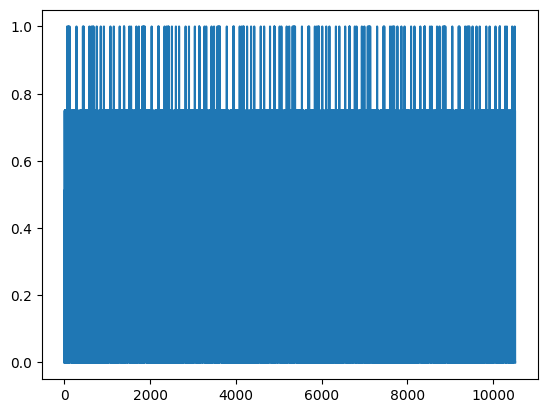

In [187]:
plt.plot(graph)

In [25]:
torch.empty(2).dtype

torch.float32

In [39]:
best_accuracy

tensor([0.9949])

In [58]:
### Testing models with test data
#################################

net_loaded = torch.load('./models/best.pkl')
total_correct = 0
total = len(test_data)
for specs, labels in test_loader:
    # feeding the model
    predictions = net_loaded(specs)
    # computing accuracy
    total_correct += sum(torch.abs(predictions-labels) <= 0.5)
# printing accuracy
print(total_correct/total)

FileNotFoundError: [Errno 2] No such file or directory: './models/best.pkl'